# Project 4: PyTorch, fully-connected neural networks, convolutional neural networks

This project is an introduction to deep learning and PyTorch---an open source deep learning framework that supports automatic differentiation. In the first part of this assignment, you will answer some questions about neural networks and implement some building blocks in PyTorch. Afterwards, you will train a feed-forward neural network and convolutional neural network on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). 

**Deep Learning Resources**

If you would like more resources on deep learning to complete the problems in Part 1, we recommend checking out the following resources:
- the Deep Learning textbook: https://www.deeplearningbook.org/
- notes from CS182 (Berkeley's deep learning course): https://cs182sp21.github.io/
- notes from CS231N (Stanford's convolutional neural networks course): https://cs231n.github.io/

**PyTorch**

If you haven't used used PyTorch at all before, we recommend that you watch the [tutorials on their website](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html). Throughout this assignment and the next, you will need to reference the documentation on [their website](https://pytorch.org/docs/stable/index.html). We'll be using PyTorch version 1.7, which comes pre-installed with Colab.

**Colab**

We intend for you to run this assignment using Google Colab. Colab is an online editor that provides free access to a GPU. To get started, make a copy of the assignemnt by clicking ``File->Save a copy in drive``. You will need to be logged into a Google account, such as your @berkeley.edu account.

To access a GPU, go to ``Edit->Notebook settings`` and select ``GPU`` in the ``Hardware accelerator`` dropdown. As soon as you run a code cell, you will be connected to a cloud instance with a GPU. 

To run a code cell, either click the play button at the top left or press ``Shift+Enter``. When you run a code cell, Colab executes it on a temporary cloud instance. Every time you open the notebook, you will be assigned a different machine, and all compute state and files on the previous machine will be lost. Therefore, you may need to re-download datasets or rerun code after a reset. Along the way, we will ask you to save certain files. To do so, click the Files button on the left, right click the file you want, and hit ``Download``. Alternatively, you can mount your Google drive to the temporary cloud instance's local filesystem and save files under a specified directory. You can find instructions for this online.

In [2]:
%%capture

# Standard library imports
from copy import deepcopy
import json
import math
import os
import pickle
import random

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm.notebook

Before proceeding, let's verify that we are connected to a GPU runtime and that ``torch`` can detect the GPU. We'll define a variable ``device`` here to use throughout the code, so that we can easily change to run on CPU for debugging.

In [3]:
assert torch.cuda.is_available()
device = torch.device("cuda") # change the argument to "cpu" in order to use the CPU for debugging purposes instead
print("Using device: {}".format(device))

Using device: cuda


## Part 1: Neural network and PyTorch basics (35 pt)

Q1: (5 pt) Imagine that you have a fully-connected neural network with the following dimensions for each layer:
- input: 32
- hidden layer 1: 128
- hidden layer 2: 64
- output layer: 10

How many parameters are in this neural network (assume that each neuron also contains a bias term)?

**Answer**: Each perceptron carries a bias, which is one parameter, and a weight for each input. The number of inputs for each perceptron is equal to the number of outputs of the previous layer / inputs because it's a fully-connected NN.
=> 128x32 weights + 128 biases in hidden layer 1,
64x128 weights + 64 biases in hidden layer 2, and
10x64 weights + 10 biases in the output layer.

=> **Total # of param: 13,130**

Q2 (5 pt): Imagine that you have an input tensor ``X`` with dimensions ``(B, H, W, C)`` where ``B = batches, H = height, W = width, and C = channels``. Write a function that modifies the shape of this tensor to be of size ``(B, H * W * C)``.

In [4]:
def flatten_non_batch_dimensions(X):
  """
  Parameters:
    X (tensor): four-dimensional tensor of size (B, H, W, C)
  Returns:
    out (tensor): two-dimensional tensor of size (B, H * W * C)
  """
  outputtensor = torch.flatten(X, start_dim=1)
  return outputtensor


#4D (2,2,3,2) tensor, each batch contains 2 matrices of size (3,2)
T_data = [[[[1., 2.], [3., 4.], [3., 4.]],
          [[5., 6.], [7., 8.], [3., 4.]]],
          [[[5., 6.], [7., 8.], [7., 8.]],
          [[1., 2.], [3., 4.], [7., 8.]]]]
testtensor = torch.tensor(T_data)

#2D (2, 8) tensor which is a 2D-matrix
#expected output:
expected = torch.tensor([[1,2,3,4,3,4,5,6,7,8,3,4],
            [5,6,7,8,7,8,1,2,3,4,7,8]])

outputtensor = flatten_non_batch_dimensions(testtensor)
print(expected == outputtensor) #True!

tensor([[True, True, True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True]])


Q3 (5 pt): Let $$f(x) = \text{ReLU}(Wx + b)$$ where $x \in \mathbb{R}^{n}$, $W \in \mathbb{R}^{m \times n}$, and $b \in \mathbb{R}^{m}$. Write a function that calculates the Jacobian of $f$ with respect to $W$. 

Hint: Your answer should be a three-dimensional tensor in $\mathbb{R}^{m \times m 
\times n}$.

In [152]:
def backprop_linear_layer_with_relu(W, b, x):
  """
  Parameters:
    W (tensor): two dimensional tensor of size (m, n)
    x (tensor): one dimensional tensor of size (n)
    b (tensor): one dimensional tensor of size (m)
  Returns:
    jacobian (tensor): three dimensional tensor of size (m, m, n)
  """  
  #three for loops i, j, k (i for row in weights, j for row in weights, and k for column in weights)
  rows_in_w = W.size()[0]
  cols_in_w = W.size()[1]
  jacobian = torch.empty((rows_in_w, rows_in_w, cols_in_w), dtype=torch.float64)

  for comp_function in range(rows_in_w):
    for row in range(rows_in_w):
      for col in range(cols_in_w):
        derivative1 = 0 
        derivative2 = 0
        #reLU derivative (simplified): x > 0: 1, else: 0
        if torch.matmul(W[comp_function,:],x) + b[comp_function] > 0:
          derivative1 = 1
        #derivative of W*x + b with respect to single weight in W[row, col]
        if comp_function == row:
          derivative2 = x[col]
        else:
          derivative2 = 0
        fullpartial = derivative1 * derivative2
        jacobian[comp_function,row,col] = fullpartial

  return jacobian


#test case
testW = torch.rand((3,2)) #mxn
testx = torch.rand(2) #n
testb = torch.rand(3) #m

#testing with torch's implementation
def relufunc(W):
  return F.relu(torch.matmul(W,testx)+testb)
print(torch.autograd.functional.jacobian(relufunc, testW))

#My implementation
value = backprop_linear_layer_with_relu(testW, testb, testx)
print(value)
print("they're the same!")

tensor([[[0.0647, 0.8429],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0647, 0.8429],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0647, 0.8429]]])
tensor([[[0.0647, 0.8429],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0647, 0.8429],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0647, 0.8429]]], dtype=torch.float64)
they're the same!


Q4 (5 pt): Recall that a loss function measures the quality of a particular set of parameters based on how well the predicted scores agree with the ground truth labels in the training data. In classification problems, the cross-entropy loss is most commonly used. Implement the cross-entropy loss given a vector of logits (the output of a classifier before the softmax) and the correct class. Make sure to avoid numerical stability issues using the trick mentioned [here](https://cs231n.github.io/linear-classify/). 

DO NOT use existing implementations of softmax or the cross-entropy loss.

In [143]:
def cal_cross_entropy_loss(logits, true_label):
  """
  Parameters:
    logits (tensor): one dimensional tensor of size (n)
    true_label (int): the index of the correct class in the range [0, n - 1]
  Returns:
    loss (float): the cross-entropy loss
  """
  #adjust to prevent numerical issues
  logits -= np.max(logits)
  cross_entropy_loss = -np.log(np.exp(logits)[true_label]/np.sum(np.exp(logits)))
  return cross_entropy_loss

#test case: random, compare output with pytorch CrossEntropyLoss function
loss = nn.CrossEntropyLoss()
logits = [3.,2.,7.,2.,1.,0.]
trueclass_idx = 2
input = torch.tensor([logits])
target = torch.tensor([trueclass_idx]) #correct class is 2
output = loss(input, target).item()
print(output)

#my implementation of cross entropy loss
myout = cal_cross_entropy_loss(logits, trueclass_idx)
print(myout)
print("values are equal (enough)!")

0.034577369689941406
0.03457741802138009
values are equal (enough)!


Q5 (5 pt): Read this article on [batch normalization](https://d2l.ai/chapter_convolutional-modern/batch-norm.html). Explain what batch normalization is and why it is useful for training deep neural networks. (Your answer should be at most 6 sentences.)

**Answer**: Batch normalization is a training normalization technique that is applied to individual layers in the network instead of normalizing the entire input sequence before feeding it into the network. For each training iteration, we consider a batch of inputs. Batch normalization in this case would normalize the output of a layer, e.g. a fully-connected layer, via the mean and standard deviation of that specified batch of inputs that the fully-connected layer processes. Usually, 50-100 distinct "cases" are considered in a batch.

Batch normalization is a useful for training deep neural networks because it accelerates the training significantly, especially with very deep neural networks (large #of layers). It allows for quicker convergence of the gradient descent backpropagation by reducing the large variances of some variables inside the network.



Q6 (5 pt): Read the Regularization section of [these course notes](https://cs231n.github.io/neural-networks-2/). Explain what L2 regularization is and what dropout is. Why does dropout require scaling of the activations either at training time/test time? (Your answer should be at most 8 sentences.)

**Answer**: Both L2 regularization and dropout are methods to control the capacity of a neural network and prevent overfitting. L2 regularization works by adding a term (1/2 * lambda * w^2) to the loss function. Large weights are penalized heavily through this (we're trying to minimize the loss function). At the end, the weight vectors will be on average small, and balanced, instead of large and unbalanced (overfitting). Dropout on the other hand is basically deactivating neurons during training at random with  a probability of (1-p) to restrict capacity.
Due to less neurons producing the output, dropout requires downscaling the output (of activations) by p when making predictions because the weights and neurons in the network are trained by only using 1-p many neurons, on average. Less neurons produce an expected output of size 1/p times the originally expected output. To achieve the originally expected output during testing, we downscale the activations when predicting by p (testing).

Q7 (5 pt): Suppose that a convolutional neural network consists of the following layers:
- a convolutional layer with 100 filters of size 3x3
- ReLU activation
- a max pooling layer of size 2x2
- a convolutional layer with 50 filters of size 2x2
- ReLU activation
- a max pooling layer of size 3x3

Further, assume that each convolutional filter also contains a bias term. How many parameters does this neural network have?

*Hint*: If you are confused by the architecture of convolutional neural networks, please read this [great guide](https://cs231n.github.io/convolutional-networks/).

**Answer**: It would depend on the input channels that the image has. Assuming it's grayscale, and there is only one channel, there are a total of **1250 parameters**.

A 3x3 convolutional filter has 9 weights plus 1 bias, totaling 10 parameters each. With 100 filters, that's 1000 parameters for the first convolutional layer.

A 2x2 convolutional filter has 4 weights + 1 bias, totaling 5 parameters each. With 50 filters, that's 250 parameters for the second convolutional layer.

The pooling layers, no matter their size, have no parameters or weights as they only calculate a specific number. Neither have the ReLU activation functions (always the same).

## Part 2: Loading and visualizing CIFAR-10 data (5 pt)

In this homework, you will be working with the CIFAR-10 dataset. This dataset consists of 60,000 32x32 RGB (red/green/blue) images where each image belongs to exactly one of ten classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. Your goal will be to train a neural network to classify images into one of these ten categories.

Below, we have provided some starter code to download the dataset and split it into training, validation, and test sets. The only function you need to be familiar with is ``get_CIFAR10_data``, which returns a map containing the images and labels for all three splits and also the mean image (the average of all images in the training set). The mean image will be useful later on when you will need to subtract the mean image from each image before feeding it into the neural network. 

The images returned by ``get_CIFAR_10_data`` have dimensions ``(H, W, C) = (32, 32, 3)``. The labels are integers in the range [0, 9] corresponding to the ten classes in the CIFAR-10 dataset.

In [7]:
%%bash
wget --quiet http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xzvf cifar-10-python.tar.gz
rm cifar-10-python.tar.gz 

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [8]:
def load_CIFAR_batch(filename):
  with open(filename, 'rb') as f:
    datadict = pickle.load(f, encoding='bytes')
    X = datadict[b'data']
    X = X.reshape(10_000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
    Y = np.asarray(datadict[b'labels']).astype("int")
    return X, Y

def load_CIFAR10(data_dir):
  # Get training data
  xs = []
  ys = []
  for b in range(1, 6):
    f = os.path.join(data_dir, "data_batch_{}".format(b))
    x_batch, y_batch = load_CIFAR_batch(f)
    xs.append(x_batch)
    ys.append(y_batch)
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)

  # Get test data
  Xte, Yte = load_CIFAR_batch(os.path.join(data_dir, "test_batch"))

  return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(num_training=49_000, num_validation=1_000, num_test=1_000):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare it
  for classifiers.
  """
  X_train, y_train, X_test, y_test = load_CIFAR10("cifar-10-batches-py")

  # Subsample and split the data
  X_val = X_train[num_training: num_training + num_validation]
  y_val = y_train[num_training: num_training + num_validation]
  X_train = X_train[: num_training]
  y_train = y_train[: num_training]
  X_test = X_test[: num_test]
  y_test = y_test[: num_test]

  # Get the mean image
  mean_image = np.mean(X_train, axis=0)

  return {
      "X_train": X_train, "y_train": y_train,
      "X_val": X_val, "y_val": y_val,
      "X_test": X_test, "y_test": y_test,
      "mean_image": mean_image
  }

In [9]:
CIFAR10_DATA = get_CIFAR10_data()
CIFAR10_CLASSES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

(5 pt) Now that we've loaded the CIFAR-10 data, we can visualize a few training example. Write code that displays the first five training examples along with their corresponding classes.

*Hint*: You might find the ``imshow`` function from ``matplotlib`` to be useful.

(32, 32, 3)


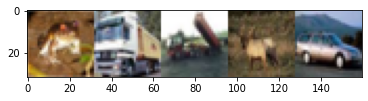

['frog', 'truck', 'truck', 'deer', 'automobile']


In [10]:
NUM_EXAMPLES_TO_DISPLAY = 5

# Show samples from CIFAR-10
images = np.empty((32,0,3), dtype=np.uint8)
classes = []
print(CIFAR10_DATA["X_train"][0,:,:,:].shape)
for idx in range(NUM_EXAMPLES_TO_DISPLAY):
  images = np.hstack((images, CIFAR10_DATA["X_train"][idx,:,:,:].astype(np.uint8)))
  classes.append(CIFAR10_CLASSES[CIFAR10_DATA["y_train"][idx]])
plt.imshow(images)
plt.show()
print(classes)

The CIFAR-10 pictures are blurry because they're only 32x32 (32 pixels in each dimension). Still, for many of the examples, you should be able to make out the object label, and our hope is that neural networks will be able to do so as well.

## Part 3: Fully-connected neural networks (20 pt)

In this part, you will train a fully-connected neural network on the CIFAR-10 dataset.

A core component in training a neural network is loading the input data (i.e. images). The way that PyTorch accomplishes this is using the ``torch.utils.data.DataLoader`` class, which contains functionality to randomly shuffle and batch the data using multithreading.

But how does PyTorch know where your data lives? To provide PyTorch that information, you will need to implement a ``torch.utils.data.Dataset`` class that 
supports two functions
- ``__len__()``: returns the size of the dataset
- ``__getitem__(index)``: returns the (image, label) pair at an index after some preprocessing

In particular, in ``__getitem__(index)``, you should
- retrieve the appropriate (image, label) pair
- subtract the mean image
- flatten the image into a 1d array as the fully-connected neural network expects a 1d input (if ``flatten=True``)
- convert both the image and label into tensors
- return the (image, label) tuple.

(10 pt) Implement the ``CIFAR10Dataset`` class. You only need to support functionality for ``flatten=True`` right now. In the next part, you will add support for ``flatten=False``.

In [11]:
class CIFAR10Dataset(torch.utils.data.Dataset):
  def __init__(self, images, labels, mean_image, flatten=True):
    self.images = images #len,32,32,3
    self.labels = labels #len times: labels, vector
    self.mean_image = mean_image #32,32,3
    self.flatten = flatten #boolean
  
  def __len__(self):
    return self.images.shape[0]

  def __getitem__(self, index):
    image = self.images[index,:,:,:]
    label = self.labels[index]
    substracted = image - self.mean_image
    if self.flatten:
      substracted = substracted.flatten()
    else:
      substracted = substracted.transpose((2, 1, 0))
    image_tensor = torch.tensor(substracted)
    label_tensor = torch.tensor(label)
    return (image_tensor, label_tensor)

If you have implemented the ``CIFAR10Dataset`` class correctly, the below two cells should run without error.

In [12]:
train_dataset = CIFAR10Dataset(CIFAR10_DATA["X_train"], CIFAR10_DATA["y_train"], CIFAR10_DATA["mean_image"], flatten=True)
val_dataset = CIFAR10Dataset(CIFAR10_DATA["X_val"], CIFAR10_DATA["y_val"], CIFAR10_DATA["mean_image"], flatten=True)
test_dataset = CIFAR10Dataset(CIFAR10_DATA["X_test"], CIFAR10_DATA["y_test"], CIFAR10_DATA["mean_image"], flatten=True)

# Run some quick checks to make sure CIFAR10Dataset class is behaving appropriately
example_image, example_label = train_dataset.__getitem__(0)
assert type(example_image) == torch.Tensor
assert type(example_label) == torch.Tensor
assert example_image.dtype == torch.float64
assert example_label.dtype == torch.int64
assert example_image.shape == torch.Size([3072])

In [13]:
# Given the Dataset objects initialized above, we can now create dataloaders for each of the three splits. 

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

(10 pt) Implement a fully-connected neural network by filling in the ``FCNetwork`` class below. The ``FCNetwork`` class is inherited from the ``nn.Module`` class and must support the ``forward`` function which takes an input ``X`` and computes the forward pass on that input. It should also support a ``compute_loss`` function, which takes an ``(X, Y)`` pair and computes the cross-entropy loss between the ground truth labels and the predicted labels.


Your neural network should consist of four linear layers with output dimensions of 100, 100, 100, and 10, respectively. Each linear layer--aside from the last--should be followed by a ReLU activation and dropout (``p=0.1``) in that order.

In [14]:
class FCNetwork(nn.Module):
  def __init__(self):
    super().__init__()

    """YOUR CODE HERE"""
    self.fc1 = nn.Linear(3072, 100)
    self.fc2 = nn.Linear(100, 100)
    self.fc3 = nn.Linear(100, 100)
    self.fc4 = nn.Linear(100, 10)
    self.dropout = nn.Dropout(p=0.1)

    # The CrossEntropyLoss computes the softmax of the scores first, so you do
    # not need to add a separate softmax layer.
    self.loss = torch.nn.CrossEntropyLoss(reduction="mean")
  
  def forward(self, X):
    """
    Computes the forward pass of the network.

    Parameters:
      X (tensor): input tensor of size (B, 3072) where B is the batch size
    Returns:
      out (tensor): output scores of size (B, 10); these are unnormalized scores
      that have not yet gone through a softmax
    """
    #each layer: ReLU, then dropout
    #pass through layer 1
    data = self.fc1(X)
    #RELU layer 1
    data = F.relu(data)
    #ran data through dropout layer 1
    data = self.dropout(data)

    #repeat for layers 2 and 3, except last
    data = self.fc2(data)
    data = F.relu(data)
    data = self.dropout(data)
    
    data = self.fc3(data)
    data = F.relu(data)
    data = self.dropout(data)

    data = self.fc4(data)

    return data
  
  def compute_loss(self, X, Y_true):
    """
    Computes the loss of the network on a minibatch.

    Paramters:
      X (tensor): batched images of size (B, 3072) where B is the batch size
      Y_true (tensor): batched labels of size (B)
    Returns:
      loss (tensor): cross-entropy loss between the network's predictions and the 
                     ground-truth labels (averaged across all samples in the minibatch)
    """

    # in your training loop:
    output = self(X) 
    batch_loss = self.loss(output, Y_true)
    return batch_loss
    
    

We have provided code to both train and evaluate the model. You do not need to modify these functions, but we recommend reading through the code, so that you understand the full workflow.

In [15]:
def train(model, train_dataloader, val_dataloader, num_epochs, lr, weight_decay, model_file):
  """
  Train the model and save its best checkpoint.

  Model performance across epochs is evaluated on the validation set. The best
  checkpoint obtained during training will be stored and disk and loaded back
  into the model at the end of training. This process is known as "early stopping."

  Parameters:
    model (nn.Module): model class
    train_dataloader (torch.utils.data.DataLoader): data loader for the training set
    val_dataloader (torch.utils.data.DataLoader): data loader for the validation set
    num_epochs (int): number of epochs the model is trained for
    lr (float): learning rate
    weight_decay (float): hyperparameter controlling L2 regularization penalty 
    model_file (str): path where model will be saved
  """
  # Create the ADAM optimizer (a variant of SGD) that will be used to train the model
  optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    betas=(0.9, 0.98),
    eps=1e-9,
    weight_decay=weight_decay
  )

  # Create the scheduler that will vary the learning rate
  scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    lr,
    epochs=num_epochs,
    steps_per_epoch=len(train_dataloader),
    pct_start=0.02  # warm up for 2% of the total training time
  )

  model = model.to(device)

  best_val_accuracy = 0.0
  for epoch in tqdm.notebook.trange(num_epochs, desc="training", unit="epoch"):
    with tqdm.notebook.tqdm(train_dataloader, desc="epoch {}".format(epoch + 1),
                            unit="batch", total=len(train_dataloader)) as batch_iterator:
      model.train()
      total_loss = 0.0
      for i, (images, labels) in enumerate(batch_iterator, start=1):
        optimizer.zero_grad() # zero out all old gradients
        images = images.to(device).float()
        labels = labels.to(device)
        loss = model.compute_loss(images, labels)
        total_loss += loss.item()
        loss.backward() # compute gradients
        optimizer.step() # backpropagate
        scheduler.step()
      
      val_accuracy = evaluate(model, val_dataloader)
      batch_iterator.set_postfix(mean_loss=total_loss / i, val_accuracy=val_accuracy)

      if val_accuracy > best_val_accuracy:
        print("Obtained a new best validation accuracy of {:.3f}, saving model checkpoint to {}".
              format(val_accuracy, model_file))
        torch.save(model.state_dict(), model_file)
        best_val_accuracy = val_accuracy
    
  model.load_state_dict(torch.load(model_file))

def evaluate(model, dataloader, predictions_fname=None):
  model = model.to(device)

  if predictions_fname is not None:
    predictions_file = open(predictions_fname, 'w')

  correct, total = 0, 0
  with torch.no_grad():
    for (images, labels) in dataloader:
      images = images.to(device).float()
      labels = labels.to(device)
      predicted_labels = model(images).argmax(-1)
      correct += (predicted_labels == labels).sum().item()
      total += labels.shape[0]

      if predictions_fname is not None:
        predicted_labels = predicted_labels.cpu().tolist()
        labels = labels.cpu().tolist()
        for (pred, truth) in zip(predicted_labels, labels):
          predictions_file.write("{} {}\n".format(pred, truth))
  
  return correct / total

(10 pt) You can now train the fully-connected network. If you have implemented the model correctly, you should achieve an accuracy of at least 0.50 on the validation set.

In [16]:
fc_network = FCNetwork()
train(fc_network, train_dataloader, val_dataloader, 20, 8e-4, 1e-4, "fc_network.pt")

training:   0%|          | 0/20 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.326, saving model checkpoint to fc_network.pt


epoch 2:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.380, saving model checkpoint to fc_network.pt


epoch 3:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.381, saving model checkpoint to fc_network.pt


epoch 4:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.420, saving model checkpoint to fc_network.pt


epoch 5:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.421, saving model checkpoint to fc_network.pt


epoch 6:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.440, saving model checkpoint to fc_network.pt


epoch 7:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.458, saving model checkpoint to fc_network.pt


epoch 8:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.462, saving model checkpoint to fc_network.pt


epoch 9:   0%|          | 0/766 [00:00<?, ?batch/s]

epoch 10:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.480, saving model checkpoint to fc_network.pt


epoch 11:   0%|          | 0/766 [00:00<?, ?batch/s]

epoch 12:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.491, saving model checkpoint to fc_network.pt


epoch 13:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.503, saving model checkpoint to fc_network.pt


epoch 14:   0%|          | 0/766 [00:00<?, ?batch/s]

epoch 15:   0%|          | 0/766 [00:00<?, ?batch/s]

epoch 16:   0%|          | 0/766 [00:00<?, ?batch/s]

epoch 17:   0%|          | 0/766 [00:00<?, ?batch/s]

epoch 18:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.505, saving model checkpoint to fc_network.pt


epoch 19:   0%|          | 0/766 [00:00<?, ?batch/s]

epoch 20:   0%|          | 0/766 [00:00<?, ?batch/s]

In [17]:
test_set_accuracy = evaluate(fc_network, test_dataloader, "fc_model_test_predictions.txt")
print("Test set accuracy: {}".format(test_set_accuracy))

Test set accuracy: 0.518


## Part 4: Convolutional Neural Network (40 pt)

(5 pt) In this section, we will train a convolutional neural network on the CIFAR-10 dataset, as opposed to a fully-connected neural network. Provide two reasons why a convolutional neural network is better suited for this task.

**Answer**: 
A CNN is better suited for image classification tasks than a fully-connected neural network (FCNN) because the CNN can recognize and take into account the order inputs and the corresponding information, which a FCNN cannot do. This is helpful for image analysis because images usually carry information in the order in which their pixels appear, and not only in the color values of those pixels. The CNN does this through filters (adjacent pixels together are meaningful!)

Additionally, the CNN is able to classify images with dramatically reduced computational resources compared to a FCNN. This is especially helpful in the image domain where we work with large files and lots of data. The CNN is better because of its has weight sharing property and it has sparser interactions than a FCNN.

(10 pt) As with the fully-connected neural network, you need to first implement the Dataset class. You should modify the CIFAR10Dataset class to support the ``flatten=False`` option because for convolutional neural networks, the image does not have to be flattened into a vector first. Like previously, ensure that you subtract the mean image. Further, permute your images to have dimensions ``(C, H, W) = (3, 32, 32)`` instead of ``(H, W, C) = (32, 32, 3)`` as that will make the model implementation easier.

Once you have made the necessary modifications, the two below code cells should run without error.

In [18]:
train_dataset = CIFAR10Dataset(CIFAR10_DATA["X_train"], CIFAR10_DATA["y_train"], CIFAR10_DATA["mean_image"], flatten=False)
val_dataset = CIFAR10Dataset(CIFAR10_DATA["X_val"], CIFAR10_DATA["y_val"], CIFAR10_DATA["mean_image"], flatten=False)
test_dataset = CIFAR10Dataset(CIFAR10_DATA["X_test"], CIFAR10_DATA["y_test"], CIFAR10_DATA["mean_image"], flatten=False)

# Run some quick checks to make sure CIFAR10Dataset class is behaving appropriately
example_image, example_label = train_dataset.__getitem__(0)
assert type(example_image) == torch.Tensor
assert type(example_label) == torch.Tensor
assert example_image.dtype == torch.float64
assert example_label.dtype == torch.int64
assert example_image.shape == torch.Size([3, 32, 32])

In [19]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

(10 pt) You will now implement the ``ConvNetwork`` class, which will specify the architecture of our convolutional neural network. Like the ``FcNetwork`` class, this class must support the ``forward`` and ``compute_loss`` methods.

Your model should have the following architecture:
- a convolutional layer with 50 5x5 filters (``stride=1, paddding=same``)
- a convolutional layer with 50 5x5 filters (``stride=1, padding=same``)
- a max pooling layer with ``kernel_size=2`` (``stride=0``)
- a convolutional layer with 50 3x3 filters (``stride=1, paddding=same``)
- a convolutional layer with 50 3x3 filters (``stride=1, paddding=same``)
- a max pooling layer with ``kernel_size=4`` (``stride=0``)
- a linear layer that predicts scores for each of the 10 classes

Each convolutional layer should consist of a 2d convolution, a batch norm layer, ReLU activation, and dropout (with ``p=0.1``) in that order.

*Hint*: Before the linear layer, you will need to flatten the activations of each image in the batch to be a 1d vector.

In [20]:
class ConvNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    """YOUR CODE HERE"""

    # 3 input image channel(r,g,b), 50 output channels (=# of filters), 5x5 square convolution, stride = 1, padding = 'same'
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=50, kernel_size=5, stride=1, padding='same')
    self.conv2 = nn.Conv2d(in_channels=50, out_channels=50, kernel_size=5, stride=1, padding='same')
    self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
    
    self.conv3 = nn.Conv2d(in_channels=50, out_channels=50, kernel_size=3, stride=1, padding='same')
    self.conv4 = nn.Conv2d(in_channels=50, out_channels=50, kernel_size=3, stride=1, padding='same')
    self.pool2 = nn.MaxPool2d(kernel_size = 4, stride = 4)

    self.linear = nn.Linear(800, 10)
    
    self.batchnorm = nn.BatchNorm2d(50)
    self.dropout = nn.Dropout(p=0.1)

    # The CrossEntropyLoss computes the softmax of the scores first, so you do
    # not need to add a separate softmax layer.
    self.loss = torch.nn.CrossEntropyLoss(reduction="mean")
  
  def forward(self, X):
    """
    Computes the forward-pass of the network.

    Parameters:
      X (tensor): input tensor of size (B, 3, 32, 32) where B is the batch size
    Returns:
      out (tensor): output scores of size (B, 10)
    """
    #conv layer 1
    data = self.dropout(F.relu(self.batchnorm(self.conv1(X))))

    #conv layer 2
    data = self.dropout(F.relu(self.batchnorm(self.conv2(data))))
    
    #maxpool layer
    data = self.pool1(data)

    #conv layer 3
    data = self.dropout(F.relu(self.batchnorm(self.conv3(data))))

    #conv layer 4
    data = self.dropout(F.relu(self.batchnorm(self.conv4(data))))

    #maxpool layer 2
    data = self.pool2(data)

    #flatten and linear
    data = torch.flatten(data, start_dim=1)
    data = self.linear(data)

    return data
  
  def compute_loss(self, X, Y_true):
    """
    Computes the loss of the network on a minibatch.

    Paramters:
      X (tensor): batched images of size (B, 3072) where B is the batch size
      Y_true (tensor): batched labels of size (B)
    Returns:
      loss (tensor): cross-entropy loss between the network's predictions and the 
                     ground-truth labels (averaged across all samples in the minibatch)
    """
    output = self(X) 
    batch_loss = self.loss(output, Y_true)
    return batch_loss


(10 pt) Train your model. If you have implemented the model correctly, you should achieve a validation accuracy of at least 0.815 using the provided hyperparameters.

In [21]:
conv_network = ConvNetwork()
train(conv_network, train_dataloader, val_dataloader, 20, 8e-3, 1e-4, "conv_network.pt")

training:   0%|          | 0/20 [00:00<?, ?epoch/s]

epoch 1:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.623, saving model checkpoint to conv_network.pt


epoch 2:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.679, saving model checkpoint to conv_network.pt


epoch 3:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.694, saving model checkpoint to conv_network.pt


epoch 4:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.708, saving model checkpoint to conv_network.pt


epoch 5:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.719, saving model checkpoint to conv_network.pt


epoch 6:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.741, saving model checkpoint to conv_network.pt


epoch 7:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.760, saving model checkpoint to conv_network.pt


epoch 8:   0%|          | 0/766 [00:00<?, ?batch/s]

epoch 9:   0%|          | 0/766 [00:00<?, ?batch/s]

epoch 10:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.770, saving model checkpoint to conv_network.pt


epoch 11:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.776, saving model checkpoint to conv_network.pt


epoch 12:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.779, saving model checkpoint to conv_network.pt


epoch 13:   0%|          | 0/766 [00:00<?, ?batch/s]

epoch 14:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.783, saving model checkpoint to conv_network.pt


epoch 15:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.795, saving model checkpoint to conv_network.pt


epoch 16:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.808, saving model checkpoint to conv_network.pt


epoch 17:   0%|          | 0/766 [00:00<?, ?batch/s]

epoch 18:   0%|          | 0/766 [00:00<?, ?batch/s]

epoch 19:   0%|          | 0/766 [00:00<?, ?batch/s]

epoch 20:   0%|          | 0/766 [00:00<?, ?batch/s]

Obtained a new best validation accuracy of 0.815, saving model checkpoint to conv_network.pt


In [48]:
test_set_accuracy = evaluate(conv_network, test_dataloader, "conv_model_test_predictions.txt")
print("Test set accuracy: {}".format(test_set_accuracy))

Test set accuracy: 0.818


(5 pt) Generate a confusion matrix for the model's predictions on the validation set. Do you see any interesting patterns?

**Interesting patterns:**
One interesting pattern in the confusion matrix is that it looks like a diagonal matrix. 
Most predictions are accuracte, which forms a diagonal in the matrix. 
Another interesting observation is that the classes are quite imbalanced in this validation set.

Further, it seems as the model is not quite able to distinguish between cat and dog all-too well.
While there are 68 correct predictions for cat (row 4, col 4), 19 incorrect predictinos (row4, col6) have been made by the model assuming it was a dog.
Same the other way around: While 69 dogs (row 6, col 6) have been classified correctly, 14 (row6, col4) of them have been classified as a cat!
I guess there were some cat-like dogs or dog-like cats involved!

In [88]:
# TODO: generate the confusion matrix and report any interesting patterns

#init variables
y_true = []  
y_pred = []
confusion_matrix = np.zeros((10,10), dtype=np.int32)

#init model
model = conv_network.to(device)

#go through data
for (images, labels) in val_dataloader:
  #make prediction
  images = images.to(device).float()
  labels = labels.to(device)
  predicted_labels = model(images).argmax(-1)

  #add to label vectors
  y_true.append(labels)
  y_pred.append(predicted_labels)

y_true = torch.cat(y_true) #1D tensor
y_pred = torch.cat(y_pred) #1D tensor

for i in range(len(y_true)):
  true_label = y_true[i].item()
  confusion_matrix[true_label, y_pred[i].item()] += 1

print('Actual \ Predicted')
print(confusion_matrix)
print(CIFAR10_CLASSES)

Actual \ Predicted
[[ 72   1   4   2   0   0   1   1   5   1]
 [  1 109   0   0   0   2   0   0   1   6]
 [  6   0  56   2   1   4   7   1   2   0]
 [  3   0   6  68   3  19   6   4   1   2]
 [  2   0   3   6  57   7   2   1   0   0]
 [  1   0   1  14   4  69   1   7   0   1]
 [  1   0   2   2   2   1  91   1   0   2]
 [  2   0   5   3   3   7   0  86   1   0]
 [  0   1   2   0   0   1   0   0 108   1]
 [  2   2   2   1   0   1   1   1   2  93]]
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Submission Instructions

Submit the following files to Gradescope:
- p4.ipynb
- fc_network.pt
- fc_model_test_predictions.txt
- conv_network.pt
- conv_model_test_predictions.txt